## ⁡⁢⁣PTME Monitoring
### Overview

### 1. ⁡⁢⁣⁣Import database⁡

In [4]:
# ⁡⁣⁢⁣Importing packages⁡

import pandas as pd
import numpy as np
from datetime import datetime
import pymysql
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
from dotenv import load_dotenv
import openpyxl

### 2. ⁡⁢⁣⁣Import personnal functions

In [5]:
# ⁡⁣⁢⁣import personnal fonction from ptme_fonction⁡
"""from caris import load_google_sheet
from ptme_fonction import save_dataframe_to_excel
from ptme_fonction import creer_colonne_match_conditional"""

'from caris import load_google_sheet\nfrom ptme_fonction import save_dataframe_to_excel\nfrom ptme_fonction import creer_colonne_match_conditional'

In [6]:
def age_range(age):
    if age < 1:
        return '< 1'
    elif age in range(1, 5):
        return '1 - 4'
    elif age in range(5, 10):
        return '5 - 9'
    elif age in range(10, 15):
        return '10 - 14'
    elif age in range(15, 18):
        return '15 - 17'
    elif age in range(18, 21):
        return '18 - 20'
    else:
        return '21+'

### 3. Dates

In [7]:
# ⁡⁣⁢⁣Dates for the most recent period⁡
from datetime import date
#today = date.today()
start_date = pd.to_datetime('2025-10-01')
end_date = pd.to_datetime('2025-12-31')
#Dates for the period before the most recent period
start_date_last = pd.to_datetime('2025-01-01')
end_date_last = pd.to_datetime(date.today())

#=================================
start_year = pd.to_datetime('2025-10-01')
end_year =pd.to_datetime ('2025-12-31')

### 4. Load database

##### 4.1 Load ptme_data database from google sheet

In [8]:
first_part = "C:\\Users\\Moise\\Downloads\\REPORTS_MEAL\\MONITORING\\PTME\\"
name_part_ptme = "site_coordonnatrices_update"
file_path_patient = first_part + name_part_ptme + ".xlsx"
site = pd.read_excel(file_path_patient, sheet_name=0, usecols=['site', 'status', 'caris_office', 'hopital', 'network', 
                     'departement', 'commune', 'section', 'latitude', 'longitude'])
coordo = pd.read_excel(file_path_patient, sheet_name=1, usecols=['site', 'statut', 'Nom hopital', 'Office', 
                     'coordonnatrices', 'Coordonnateurs , coordonnatrices Clubs SIY', 
                     'nom_complet_agent', 'username_agent'])
display(site.head(1))
display(coordo.head(1))

,status,site,caris_office,hopital,network,departement,commune,section,latitude,longitude
0,Actif,MCH/DSCA,Gonaives,Dispensaire Ste Claire d’Assise,CMMB,Artibonite,Dessalines,Dessalines,19.25917,-72.51613


,site,statut,Nom hopital,Office,coordonnatrices,"Coordonnateurs , coordonnatrices Clubs SIY",nom_complet_agent,username_agent
0,PIL/HOEP,Actif,Hopital Esperance de Pilate,CAP,Cely Adline/Presumé Maxime Antoine Jr,Presumé Maxime Antoine Jr,Rosanie Beauliva,1rosanie


##### 4.2 Load Patient code database from Commcare

In [9]:
# Correct the file path by adding a backslash at the end of `first_part`
first_part = "C:\\Users\\Moise\\Downloads\\REPORTS_MEAL\\MONITORING\\OEV\\"
name_part_ptme = "Club_OEV"
file_path_patient = first_part + name_part_ptme + ".xlsx"

# Load the Excel file and read the second sheet (sheet_name=1)
club_child = pd.read_excel(file_path_patient, sheet_name=1)

# Display the number of rows and the first two rows of the DataFrame
display(club_child.shape[0])
display(club_child.head(2))

1251

,departement,commune,section,site,hospital_name,id_hospital,patient_code,id_patient,sex,date_of_birth,...,inh_initiation_date,inh_completion_date,indetectable_ou_inf_1000,eligibility,last_session_date,is_actually_in_club,age,network,is_ugp,office
0,Nord,Cap Haitien,2ème Haut du Cap,CAP/CDSF,CDS La Fossette,23,CAP/CDSF/AJ1114R,16769,F,2014-11-28,...,0,0,OUI,YES,2025-03-19,yes,10,IMA,No,CAP
1,Nord,Cap Haitien,2ème Haut du Cap,CAP/CDSF,CDS La Fossette,23,CAP/CDSF/ST01726,20097,F,2008-09-10,...,0,0,OUI,NO,2025-03-19,yes,16,IMA,No,CAP


##### 4.3 Load Comptage de menage database from Commcare

In [10]:
# Correct the file path by adding a backslash at the end of `first_part`
first_part = "C:\\Users\\Moise\\Downloads\\REPORTS_MEAL\\MONITORING\\OEV\\"
name_part_ptme = "household_child"
file_path_patient = first_part + name_part_ptme + ".xlsx"

# Load the Excel file and read the second sheet (sheet_name=1)
hh_child = pd.read_excel(file_path_patient, sheet_name=0)

# Display the number of rows and the first two rows of the DataFrame
display(hh_child.shape[0])
display(hh_child.head(2))

13517

,number,caseid,cty,dob,first_name,gender,hiv_test,hiv_test_date,hiv_test_result,hospital_code,...,non_consent_reason,other_infant_relationship,age_in_year,caregiver_yes_no,code_incorrect_raison,confirmation_code_by_agent,consent,has_schooling_form_2021,school_name,Full_code_patient_menage1
0,0,5cdc6db5-3642-4cd2-aa2f-f4c2acf6a5b0,---,1970-08-09,wisly,1.0,---,---,---,---,...,---,---,44,1,---,---,---,---,---,---
1,1,2aaba2b2-51a3-4a70-812e-98d25cc4d63f,pap,2020-08-07,oioio,1.0,2,---,---,cfth,...,---,---,---,---,---,---,---,---,---,---


In [11]:
#data for only child in club
hh_child.rename(columns = {'main_infant_code':'patient_code'}, 
              inplace = True)
hhm_club = hh_child[hh_child['patient_code'].str.lower().isin(club_child['patient_code'].str.lower())]
hhm_club['patient_code'] = hhm_club['patient_code'].str.upper()
#preparing age columns
hhm_club.loc[(hhm_club.age_in_year == '---'), 'age_in_year'] = ''
hhm_club['age_in_year'] = pd.to_numeric(hhm_club['age_in_year'])
hhm_club['age_range'] = hhm_club['age_in_year'].map(age_range)
#Replacing code by true gender values
hhm_club.loc[(hhm_club.gender == 1), 'gender'] = 'Male'
hhm_club.loc[(hhm_club.gender == 2), 'gender'] = 'Female'
display(hhm_club.shape[0])
display(hhm_club.head(2))
#display(hhm_club['patient_code']).value_counts

5749

,number,caseid,cty,dob,first_name,gender,hiv_test,hiv_test_date,hiv_test_result,hospital_code,...,other_infant_relationship,age_in_year,caregiver_yes_no,code_incorrect_raison,confirmation_code_by_agent,consent,has_schooling_form_2021,school_name,Full_code_patient_menage1,age_range
0,0,5cdc6db5-3642-4cd2-aa2f-f4c2acf6a5b0,---,1970-08-09,wisly,Male,---,---,---,---,...,---,44,1,---,---,---,---,---,---,21+
79,79,63a01e3e-0d40-445b-816f-e7e333c14aba,---,1976-06-16,Jacques,Male,---,---,---,---,...,---,44,1,---,---,---,---,---,---,21+


In [12]:
display(hhm_club.value_counts('patient_code'))

patient_code
PAP/CMSP/ST01535     32
PAP/CMSP/ST01354     27
PAP/NPFS/ST01670     26
PAP/CMSP/ST01389     25
PAP/NPFS/ST01577     24
                     ..
PEG/HNDP/ST01710      1
SMA/CSSM/PCR00092     1
MCH/HCHM/ST01742      1
PIL/HOEP/ST03361      1
CAP/CALT/ST01414      1
Name: count, Length: 1114, dtype: int64

In [13]:
hhm_club.to_excel(f'Comptage_OEV_{pd.Timestamp.today().strftime("%Y-%m-%d")}.xlsx', index=False)

In [ ]:
# Ensure column renaming is consistent and avoids conflicts
hhm_club.rename(columns={'full_code_patient_menage': 'patient_code2'}, inplace=True)
club_child.rename(columns={'patient_code': 'patient_code2'}, inplace=True)

In [ ]:
def merge_and_extend(working_data, site, on='site', suffixes = ('_hmm', '_club')):
    """
    Merge the working_data DataFrame with the site DataFrame and extend it with all columns from site.

    Args:
        working_data (pd.DataFrame): The main DataFrame to merge.
        site (pd.DataFrame): The DataFrame containing additional columns to merge.
        on (str): The column name to merge on. Default is 'site'.

    Returns:
        pd.DataFrame: The merged DataFrame with all columns from both DataFrames.
    """
    # Merge the DataFrames
    merged_data = working_data.merge(site, on=on, how='left')

    # Add missing columns from site to merged_data
    for col in site.columns:
        if col not in merged_data.columns:
            merged_data[col] = site[col]

    # Return the merged DataFrame
    return merged_data

In [ ]:
merged_data = hhm_club.merge(club_child, on='patient_code', how='left', suffixes = ('_hmm', '_club'))

KeyError: 'patient_code'

In [ ]:

# Merge hhm_club with club_child on 'patient_code2'
hhm_club = hhm_club.merge(club_child, on='patient_code2', how='left', suffixes = ('_hmm', '_club'))

In [ ]:
# Display the first two rows and the shape of the resulting DataFrame
display(hhm_club.head(2))
hhm_club.shape

,number,caseid,cty,dob,first_name_x,gender,hiv_test,hiv_test_date,hiv_test_result,hospital_code,...,inh_initiation_date,inh_completion_date,indetectable_ou_inf_1000,eligibility,last_session_date,is_actually_in_club,age,network,is_ugp,office
0,0,5cdc6db5-3642-4cd2-aa2f-f4c2acf6a5b0,---,1970-08-09,wisly,Male,---,---,---,---,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79,63a01e3e-0d40-445b-816f-e7e333c14aba,---,1976-06-16,Jacques,Male,---,---,---,---,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(5749, 133)

In [ ]:
#=======================================================================================================================

#Function to get the age range
def age_range(age):
    if age < 1:
        return '< 1'
    elif age in range(1, 5):
        return '1 - 4'
    elif age in range(5, 10):
        return '5 - 9'
    elif age in range(10, 15):
        return '10 - 14'
    elif age in range(15, 18):
        return '15 - 17'
    elif age in range(18, 21):
        return '18 - 20'
    else:
        return '21+'

hhm_club['age_range'] = hhm_club['age'].map(age_range)
hhm_club = hhm_club[hhm_club['age_range'] != '21+']
#==================================================================================

hhm_club.head()

KeyError: 'age'

In [ ]:
#creating the siblings dataset and the dataset for the other kids
hhm_ff = hhm_club[hhm_club.infant_relationship == str(3)]
hhm_other = hhm_club[hhm_club.infant_relationship != str(3)]
hhm_other.loc[(hhm_other['name'] == 'Metellus Rose Derlove'), 'gender'] = 'Female'


#Size
hhm_ff_stat = hhm_club[(hhm_club.infant_relationship == str(3)) & (~hhm_club.age_range.isin(['18 - 20', '21+']))]
hhm_other_stat = hhm_club[(hhm_club.infant_relationship != str(3)) & (~hhm_club.age_range.isin(['18 - 20', '21+']))]
hhm_ff_stat.shape

hhm_other_stat.loc[(hhm_other_stat['name'] == 'Metellus Rose Derlove'), 'gender'] = 'Female'
hhm_other_stat.shape

AttributeError: 'DataFrame' object has no attribute 'age_range'

In [ ]:
hhm_club.to_excel('Comptage_OEV_FY24Q2_04232024.xlsx', index = False)

##### 4.4 Load Index testing database from Commcare

In [ ]:
# Lire et préparer un autre fichier Excel
name_part_ptme = "household mother "
# file_path_hh_mother = first_part + name_part_ptme + datetime.now().strftime("%Y-%m-%d") + ".xlsx"
file_path_hh_mother = first_part + name_part_ptme + "2025-03-13" + ".xlsx"
compt_ptme4 = pd.read_excel(file_path_hh_mother, sheet_name=0)

compt_ptme1 = compt_ptme4[['patient_code', 'age_in_year', 'ptme_relationship', 'full_code_patient_menage',
                          'hiv_test', 'hiv_test_result', 'caseid', 'non_consent_reason']]
compt_ptme1['patient_code'] = compt_ptme1['patient_code'].str.strip()
compt_ptme1['age_in_year'] = pd.to_numeric(compt_ptme1['age_in_year'], errors='coerce')
# Afficher les deux premières lignes
display(compt_ptme1.shape[0])
display(compt_ptme1.head(2))

31017

,patient_code,age_in_year,ptme_relationship,full_code_patient_menage,hiv_test,hiv_test_result,caseid,non_consent_reason
0,PAP/CHAP/TESTMOM,NaN,---,---,non,---,ec8e868f-acea-4785-9d86-8c430399ceaa,---
1,PAP/CHAP/TESTMOM,NaN,---,---,oui,encours,a82caeb5-cfc1-4e76-bfea-b5efb67894f2,---


### 5. Data cleaning

#### 5.1. Data cleaning for comptage database from Ajout de menages ptme [officiel]

In [ ]:
comptage = compt_ptme0[[
    "form.household_collection_date",
    "form.is_accepted",
    "form.not_accepted_reason",
    "form.household_number",
    "username",
    "form_link",
    "form.case.@case_id",
    "form.case.@date_modified",
    "form.case.update.household_number"
]].rename(columns={
    'form.case.@case_id': 'case_id',
    'form.is_accepted': 'is_accepted',
    'form.case.@date_modified': 'collection_date'
})

In [ ]:
comptage.head(2)

,form.household_collection_date,is_accepted,form.not_accepted_reason,form.household_number,username,form_link,case_id,collection_date,form.case.update.household_number
0,---,---,---,2,2boulez,https://www.commcarehq.org/a/caris-test/report...,3c5a623af057e23a32ae4000_18965,2020-08-06 23:39:49,---
1,---,---,---,1,2boulez,https://www.commcarehq.org/a/caris-test/report...,3c5a623af057e23a32ae4000_73766,2020-08-06 23:59:28,1


In [ ]:
# Convertir la colonne en type datetime
comptage["collection_date"] = pd.to_datetime(comptage["collection_date"], errors='coerce')

# Définir les bornes de la plage de dates
date_debut = pd.to_datetime("2024-01-01")
date_fin = pd.to_datetime("today")

### 3. Generate some Indicators from ovc_data

In [ ]:
ovc_data.drop_duplicates(subset='patient_code', inplace=True)
print(f"Number of PMTCT woman for the semester: {ovc_data.shape[0]}")

Number of PMTCT woman for the semester: 4363


In [ ]:
# List of PMTCT women for the semester
real_ptme = ovc_data[(ovc_data.allaitante == 'yes') | (ovc_data.enceinte == 'yes')]
print(f"Number of real PMTCT women for the semester: {real_ptme.shape[0]}")

Number of real PMTCT women for the semester: 2196


In [ ]:

club_ptme = ovc_data[(ovc_data.club_q1 == 'yes') | (ovc_data.club_q2 == 'yes')]
print(f"Number of women in club for the semester: {club_ptme.shape[0]}")

Number of women in club for the semester: 1953


In [ ]:
# List of women in club for the semester
ptme_enceinte = ovc_data[(ovc_data.enceinte == 'yes')]
print(f"Number of pregnant PMTCT woman for the semester: {ptme_enceinte.shape[0]}")

Number of pregnant PMTCT woman for the semester: 197


In [ ]:
# List of women in club for the semester
club_woman_ptme = ovc_data[((ovc_data.club_q1 == 'yes') | (ovc_data.club_q2 == 'yes')) & ((ovc_data.allaitante == 'yes') | (ovc_data.enceinte == 'yes'))]
print(f"Number of real PMTCT women in club for the semester: {club_woman_ptme.shape[0]}")

Number of real PMTCT women in club for the semester: 922


In [ ]:
# List of women in club for the semester
no_club_woman_ptme = ovc_data[~((ovc_data.club_q1 == 'yes') | (ovc_data.club_q2 == 'yes')) & ((ovc_data.enceinte == 'yes'))]
print(f"Number of pregnant women not in club for the semester: {no_club_woman_ptme.shape[0]}")

Number of pregnant women not in club for the semester: 175


In [ ]:
ovc_data['participation'].value_counts()

participation
aucune_participation    2410
En_club_q1_yes_q2_no    1108
En_club_q1_no_q2_yes     845
Name: count, dtype: int64

### 5. Generate the working database and the index database with some merging

In [ ]:
comptage = comptage.merge(id_patient, on='case_id', how='left')
comptage.shape[0]
comptage.head(2)

11434

,form.household_collection_date,is_accepted,form.not_accepted_reason,form.household_number,username,form_link,case_id,collection_date,form.case.update.household_number,patient_code,code
0,---,---,---,2,2boulez,https://www.commcarehq.org/a/caris-test/report...,3c5a623af057e23a32ae4000_18965,2020-08-06 23:39:49,---,PAP/CHAP/TESTMOM,NaN
1,---,---,---,1,2boulez,https://www.commcarehq.org/a/caris-test/report...,3c5a623af057e23a32ae4000_73766,2020-08-06 23:59:28,1,PAP/CHAP/TESTMOM2,NaN


#### 5.1. Merging ptme_data with the id_patient database

In [ ]:
mapping_p = {'both': 'yes', 'left_only': 'no'}
on_hivhaiti = creer_colonne_match_conditional(club_ptme, id_patient[['patient_code', 'case_id']], on='patient_code', nouvelle_colonne='on_commCare', mapping=mapping_p)
# Affichage du résultat
display(on_hivhaiti[['patient_code','on_commCare']].head(2))
print(on_hivhaiti[['patient_code','on_commCare']].shape[0])
print(on_hivhaiti[['patient_code','on_commCare']].isna().sum())
print(on_hivhaiti['on_commCare'].value_counts())

,patient_code,on_commCare
0,CAP/CALT/ST00038,yes
1,CAP/CALT/ST00073,yes


1963
patient_code    0
on_commCare     0
dtype: int64
on_commCare
yes    1945
no       18
Name: count, dtype: int64


#### 5.2. Merging on_hivhaiti database with the comptage database

In [ ]:
mapping_p = {'both': 'yes', 'left_only': 'no'}
comptage_on_hiv = creer_colonne_match_conditional(on_hivhaiti, comptage, on='patient_code', nouvelle_colonne='comptage', mapping=mapping_p)
# Affichage du résultat
comptage_on_hiv.drop_duplicates(subset='patient_code', inplace=True)
display(comptage_on_hiv[['patient_code', 'comptage']].head(2))
print(comptage_on_hiv[['patient_code', 'comptage']].shape[0])
print(comptage_on_hiv[['patient_code', 'comptage']].isna().sum())
print(comptage_on_hiv['comptage'].value_counts())

,patient_code,comptage
0,CAP/CALT/ST00038,no
1,CAP/CALT/ST00073,yes


1953
patient_code    0
comptage        0
dtype: int64
comptage
yes    1769
no      184
Name: count, dtype: int64


In [ ]:
mapping_p = {'both': 'yes', 'left_only': 'no'}
compt_ptme2 = compt_ptme1.drop_duplicates(subset='patient_code')
working_data = creer_colonne_match_conditional(comptage_on_hiv, compt_ptme2, on='patient_code', nouvelle_colonne='testing', mapping=mapping_p)
# Affichage du résultat
display(working_data[['patient_code','on_commCare','comptage','testing']].head(2))
print(working_data[['patient_code','on_commCare','comptage','testing']].shape[0])
print(working_data[['patient_code','on_commCare','comptage','testing']].isna().sum())
print(working_data['comptage'].value_counts())
print(working_data['on_commCare'].value_counts())
print(working_data['testing'].value_counts())

,patient_code,on_commCare,comptage,testing
0,CAP/CALT/ST00038,yes,no,no
1,CAP/CALT/ST00073,yes,yes,yes


1953
patient_code    0
on_commCare     0
comptage        0
testing         0
dtype: int64
comptage
yes    1769
no      184
Name: count, dtype: int64
on_commCare
yes    1935
no       18
Name: count, dtype: int64
testing
yes    1263
no      690
Name: count, dtype: int64


In [ ]:
comptage_ptme = working_data[['patient_code','on_commCare','comptage','testing']]

In [ ]:
# Merge the working_data DataFrame with the site DataFrame
merged_data = working_data.merge(site, on='site', how='left')

# Conserver toutes les colonnes de merged_data et ajouter celles de site
for col in site.columns:
    if col not in merged_data.columns:
        merged_data[col] = site[col]

# Afficher les premières lignes pour vérifier
display(merged_data.head(1))

,site,Hospital,network_name,first_name,last_name,dob,id_patient,patient_code,created_at,age,...,testing,status,caris_office,hopital,network,departement,commune,section,latitude,longitude
0,CAP/CALT,---,---,Joseph,Roseline,1980-01-15 00:00:00,---,CAP/CALT/ST00038,---,---,...,no,Actif,Cap-Haitien,CAL de Trou du Nord,CMMB,Nord-Est,Trou-du-Nord,Trou-du-Nord,19.61273,-72.02686


In [ ]:
def merge_and_extend(working_data, site, on='site'):
    """
    Merge the working_data DataFrame with the site DataFrame and extend it with all columns from site.

    Args:
        working_data (pd.DataFrame): The main DataFrame to merge.
        site (pd.DataFrame): The DataFrame containing additional columns to merge.
        on (str): The column name to merge on. Default is 'site'.

    Returns:
        pd.DataFrame: The merged DataFrame with all columns from both DataFrames.
    """
    # Merge the DataFrames
    merged_data = working_data.merge(site, on=on, how='left')

    # Add missing columns from site to merged_data
    for col in site.columns:
        if col not in merged_data.columns:
            merged_data[col] = site[col]

    # Return the merged DataFrame
    return merged_data

In [ ]:
# Merge the working_data DataFrame with the site DataFrame
final_data = merged_data.merge(coordo, on='site', how='left')

# Conserver toutes les colonnes de merged_data et ajouter celles de site
for col in coordo.columns:
    if col not in merged_data.columns:
        final_data[col] = coordo[col]

# Afficher les premières lignes pour vérifier
display(final_data.head(1))

# Vérifier les valeurs uniques dans certaines colonnes
print(final_data[['patient_code','on_commCare','comptage','testing']].shape[0])
print(final_data['network'].value_counts())
print(final_data['Office'].value_counts())

,site,Hospital,network_name,first_name,last_name,dob,id_patient,patient_code,created_at,age,...,section,latitude,longitude,statut,Nom hopital,Office,coordonnatrices,"Coordonnateurs , coordonnatrices Clubs SIY",nom_complet_agent,username_agent
0,CAP/CALT,---,---,Joseph,Roseline,1980-01-15 00:00:00,---,CAP/CALT/ST00038,---,---,...,Trou-du-Nord,19.61273,-72.02686,Actif,Hopital Esperance de Pilate,CAP,Cely Adline/Presumé Maxime Antoine Jr,Presumé Maxime Antoine Jr,Rosanie Beauliva,1rosanie


1953
network
Santé      705
CMMB       661
GHESKIO    211
FOSREF      87
BRIDGE      84
CDS         68
UGP         34
ICAP        20
PIH          1
Name: count, dtype: int64
Office
PAP-PAP    30
CAP        24
GON        18
PAP-CAR    11
PDP         6
Name: count, dtype: int64


In [ ]:
ptme_woman0 = working_data[(working_data.allaitante == 'yes') | (working_data.enceinte == 'yes')]
print(f"Number of PTME women with for the semester: {ptme_woman0.shape[0]}")
pregnant_woman = working_data[working_data['enceinte'] == 'yes']
print(f"Number of pregnant women with for the semester: {pregnant_woman.shape[0]}")
pregnant_woman_in_club = working_data[((working_data.club_q1 == 'yes') | (working_data.club_q2 == 'yes')) & ((working_data.enceinte == 'yes'))]
print(f"Number of pregnant women in club for the semester: {pregnant_woman_in_club.shape[0]}")
pregnant_woman_with_testing = pregnant_woman_in_club[pregnant_woman_in_club['testing'] == 'yes']
print(f"Number of pregnant women with Household count for the semester: {pregnant_woman_with_testing.shape[0]}")
pregnant_woman_with_comptage = pregnant_woman_in_club[pregnant_woman_in_club['comptage'] == 'yes']
print(f"Number of pregnant women with testing for their child: {pregnant_woman_with_comptage.shape[0]}")

Number of PTME women with for the semester: 2196
Number of pregnant women with for the semester: 197
Number of pregnant women in club for the semester: 22
Number of pregnant women with Household count for the semester: 17
Number of pregnant women with testing for their child: 20


In [ ]:
ptme_woman0 = working_data[(working_data.allaitante == 'yes') | (working_data.enceinte == 'yes')]
print(f"Number of PTME women with for the semester: {ptme_woman0.shape[0]}")

Number of PTME women with for the semester: 2196


In [ ]:
pregnant_woman = working_data[working_data['enceinte'] == 'yes']
print(f"Number of pregnant women with for the semester: {pregnant_woman.shape[0]}")

Number of pregnant women with for the semester: 197


In [ ]:
pregnant_woman_no_in_club = working_data[~((working_data.club_q1 == 'yes') | (working_data.club_q2 == 'yes')) & ((working_data.enceinte == 'yes'))]
print(f"Number of pregnant women not in club for the semester: {pregnant_woman_no_in_club.shape[0]}")

Number of pregnant women not in club for the semester: 175


In [ ]:
pregnant_woman_in_club = working_data[((working_data.club_q1 == 'yes') | (working_data.club_q2 == 'yes')) & ((working_data.enceinte == 'yes'))]
print(f"Number of pregnant women in club for the semester: {pregnant_woman_in_club.shape[0]}")

Number of pregnant women in club for the semester: 22


In [ ]:
pregnant_woman_with_testing = pregnant_woman_in_club[pregnant_woman_in_club['testing'] == 'yes']
print(f"Number of pregnant women with Household count for the semester: {pregnant_woman_with_testing.shape[0]}")

Number of pregnant women with Household count for the semester: 17


In [ ]:
pregnant_woman_with_comptage = pregnant_woman_in_club[pregnant_woman_in_club['comptage'] == 'yes']
print(f"Number of pregnant women with testing for the semester: {pregnant_woman_with_comptage.shape[0]}")

Number of pregnant women with testing for the semester: 20


In [ ]:
mapping_p = {'both': 'yes', 'left_only': 'no'}
stat_ptme_index = creer_colonne_match_conditional(compt_ptme1, club_ptme, on='patient_code', nouvelle_colonne='testing', mapping=mapping_p)
# Affichage du résultat
print(stat_ptme_index[['patient_code', 'testing']].shape[0])
print(stat_ptme_index['testing'].value_counts())
stat_ptme_index = stat_ptme_index[stat_ptme_index['testing']=='yes']
int(stat_ptme_index[['patient_code', 'testing']].shape[0])

31017
testing
no     25275
yes     5742
Name: count, dtype: int64


5742

In [ ]:
serv_ptme = working_data.copy(deep =True)
serv_ptme1 = serv_ptme[
    (serv_ptme['dead'] == "0") & (serv_ptme['abandoned'] == '0') & 
    ((serv_ptme['club_q1'] == "yes") | (serv_ptme['club_q2'] == "yes")) &
    (serv_ptme['is_patient_on_hivhaiti'] != 'no')
].drop(columns=['is_dead'])

In [ ]:
save_dataframe_to_excel(stat_ptme_index, 'stat_ptme_index')
save_dataframe_to_excel(working_data, 'working_data')

DataFrame saved to C:\Users\Moise\Downloads\REPORTS_MEAL\DATA\PTME\stat_ptme_index.xlsx


'C:\\Users\\Moise\\Downloads\\REPORTS_MEAL\\DATA\\PTME\\stat_ptme_index.xlsx'

DataFrame saved to C:\Users\Moise\Downloads\REPORTS_MEAL\DATA\PTME\working_data.xlsx


'C:\\Users\\Moise\\Downloads\\REPORTS_MEAL\\DATA\\PTME\\working_data.xlsx'

In [ ]:
serv_ptme = working_data.copy(deep =True)
serv_ptme1 = serv_ptme[
    (serv_ptme['dead'] == "0") & (serv_ptme['abandoned'] == '0') & 
    ((serv_ptme['club_q1'] == "yes") | (serv_ptme['club_q2'] == "yes")) &
    (serv_ptme['is_patient_on_hivhaiti'] != 'no')
].drop(columns=['is_dead'])

stat_ptme_index = stat_ptme_index[[
    'patient_code', 'age_in_year', 'ptme_relationship', 'full_code_patient_menage',
    'hiv_test', 'hiv_test_result', 'non_consent_reason', 'caseid'
]]
stat_ptme_index['age_in_year'] = stat_ptme_index['age_in_year'].fillna(0).astype(int)

### Effectuer les transformations nécessaires sur stat_ptme_index

In [ ]:
# Total des enfants
eff_enf = stat_ptme_index[(stat_ptme_index['ptme_relationship'] == "2") & (stat_ptme_index['age_in_year'].between(0, 17))]
eff_enf = eff_enf['patient_code'].value_counts().reset_index().rename(columns={'index': 'patient_code', 'patient_code': '# Enfants'})

In [ ]:
# Enfants testés
enf_test = stat_ptme_index[(stat_ptme_index['ptme_relationship'] == "2") & (stat_ptme_index['age_in_year'].between(0, 17)) & 
                           (stat_ptme_index['hiv_test'].isin(["1", "oui"]))]
enf_test = enf_test['patient_code'].value_counts().reset_index().rename(columns={'index': 'patient_code', 'patient_code': '# Enfants testés'})

In [ ]:
# Enfants non testés
enf_non_test = stat_ptme_index[(stat_ptme_index['ptme_relationship'] == "2") & (stat_ptme_index['age_in_year'].between(0, 17)) & 
                               (stat_ptme_index['hiv_test'].isin(["2", "non"])) & (stat_ptme_index['non_consent_reason'] == "---")]
enf_non_test = enf_non_test['patient_code'].value_counts().reset_index().rename(columns={'index': 'patient_code', 'patient_code': '# Enfants non testés'})


In [ ]:
# Enfants VIH+ avec code de ménage complet
enf_vih_pos = stat_ptme_index[(stat_ptme_index['ptme_relationship'] == "2") & (stat_ptme_index['age_in_year'].between(0, 17)) & 
                              (stat_ptme_index['hiv_test_result'] == "positif") & (stat_ptme_index['hiv_test'].isin(["1", "oui"])) & 
                              (~stat_ptme_index['full_code_patient_menage'].isin(["//", "---"]))]
enf_vih_pos = enf_vih_pos['patient_code'].value_counts().reset_index().rename(columns={'index': 'patient_code', 'patient_code': '# Enfants VIH+ avec ST code'})

In [ ]:
# Total des enfants VIH+
enf_vih_pos_total = stat_ptme_index[(stat_ptme_index['ptme_relationship'] == "2") & (stat_ptme_index['age_in_year'].between(0, 17)) & 
                                    (stat_ptme_index['hiv_test_result'] == "positif") & (stat_ptme_index['hiv_test'].isin(["1", "oui"]))]
enf_vih_pos_total = enf_vih_pos_total['patient_code'].value_counts().reset_index().rename(columns={'index': 'patient_code', 'patient_code': '# Enfants VIH+'})


In [ ]:
# Enfants VIH-
enf_vih_neg = stat_ptme_index[(stat_ptme_index['ptme_relationship'] == "2") & (stat_ptme_index['age_in_year'].between(0, 17)) & 
                              (stat_ptme_index['hiv_test_result'] == "negatif") & (stat_ptme_index['hiv_test'].isin(["1", "oui"]))]
enf_vih_neg = enf_vih_neg['patient_code'].value_counts().reset_index().rename(columns={'index': 'patient_code', 'patient_code': '# Enfants VIH-'})


In [ ]:
# Pas d'information sur le test
no_info_status = stat_ptme_index[(stat_ptme_index['ptme_relationship'] == "2") & (stat_ptme_index['age_in_year'].between(0, 17)) & 
                                 (stat_ptme_index['hiv_test'] == "1") & (~stat_ptme_index['hiv_test_result'].isin(["positif", "negatif"]))]
no_info_status = no_info_status['patient_code'].value_counts().reset_index().rename(columns={'index': 'patient_code', 'patient_code': '# no_info_status'})

# Sur commcare

In [ ]:
commcare_ptme_yes = working_data[working_data['on_commCare'] == "yes"]

In [ ]:

# Pas sur commcare
commcare_ptme_no = working_data[working_data['on_commCare'] == "no"]

In [ ]:
"""import pandas as pd
import dash
from dash import html, dash_table

# Ajouter les nouvelles colonnes avec conditions stat_ptme_index
stat_ptme_index['# Enfants'] = ((stat_ptme_index['ptme_relationship'] == "2") & (stat_ptme_index['age_in_year'].between(0, 17))).astype(int)
stat_ptme_index['# Enfants testés'] = ((stat_ptme_index['# Enfants'] == 1) & (stat_ptme_index['hiv_test'].isin(["1", "oui"]))).astype(int)
stat_ptme_index['# Enfants non testés'] = ((stat_ptme_index['# Enfants'] == 1) & (stat_ptme_index['hiv_test'].isin(["2", "non"])) & (stat_ptme_index['non_consent_reason'] == "---")).astype(int)
stat_ptme_index['# Enfants VIH+ avec ST code'] = ((stat_ptme_index['# Enfants'] == 1) & (stat_ptme_index['hiv_test_result'] == "positif") & (stat_ptme_index['hiv_test'].isin(["1", "oui"])) & (~stat_ptme_index['full_code_patient_menage'].isin(["//", "---"]))).astype(int)
stat_ptme_index['# Enfants VIH+'] = ((stat_ptme_index['# Enfants'] == 1) & (stat_ptme_index['hiv_test_result'] == "positif") & (stat_ptme_index['hiv_test'].isin(["1", "oui"]))).astype(int)
stat_ptme_index['# Enfants VIH-'] = ((stat_ptme_index['# Enfants'] == 1) & (stat_ptme_index['hiv_test_result'] == "negatif") & (stat_ptme_index['hiv_test'].isin(["1", "oui"]))).astype(int)
stat_ptme_index['# no_info_status'] = ((stat_ptme_index['# Enfants'] == 1) & (stat_ptme_index['hiv_test'] == "1") & (~stat_ptme_index['hiv_test_result'].isin(["positif", "negatif"]))).astype(int)

# Ajouter les informations sur commCare
stat_ptme_index['on_commCare'] = stat_ptme_index['patient_code'].isin(commcare_ptme_yes['patient_code']).astype(int)"""

# Ajouter les patients non acceptés
#stat_ptme_index['is_accepted'] = stat_ptme_index['patient_code'].isin(no_accept['patient_code']).astype(int)

"""# Création de l'application Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    dash_table.DataTable(
        columns=[{"name": col, "id": col} for col in stat_ptme_index.columns],
        data=stat_ptme_index.to_dict('records'),
        style_header={'backgroundColor': '#800000', 'color': 'white'},
        page_size=10,
        export_format="xlsx"
    )
])

if __name__ == '__main__':
    app.run(debug=True)"""


'import pandas as pd\nimport dash\nfrom dash import html, dash_table\n\n# Ajouter les nouvelles colonnes avec conditions stat_ptme_index\nstat_ptme_index[\'# Enfants\'] = ((stat_ptme_index[\'ptme_relationship\'] == "2") & (stat_ptme_index[\'age_in_year\'].between(0, 17))).astype(int)\nstat_ptme_index[\'# Enfants testés\'] = ((stat_ptme_index[\'# Enfants\'] == 1) & (stat_ptme_index[\'hiv_test\'].isin(["1", "oui"]))).astype(int)\nstat_ptme_index[\'# Enfants non testés\'] = ((stat_ptme_index[\'# Enfants\'] == 1) & (stat_ptme_index[\'hiv_test\'].isin(["2", "non"])) & (stat_ptme_index[\'non_consent_reason\'] == "---")).astype(int)\nstat_ptme_index[\'# Enfants VIH+ avec ST code\'] = ((stat_ptme_index[\'# Enfants\'] == 1) & (stat_ptme_index[\'hiv_test_result\'] == "positif") & (stat_ptme_index[\'hiv_test\'].isin(["1", "oui"])) & (~stat_ptme_index[\'full_code_patient_menage\'].isin(["//", "---"]))).astype(int)\nstat_ptme_index[\'# Enfants VIH+\'] = ((stat_ptme_index[\'# Enfants\'] == 1) & (sta

'# Création de l\'application Dash\napp = dash.Dash(__name__)\n\napp.layout = html.Div([\n    dash_table.DataTable(\n        columns=[{"name": col, "id": col} for col in stat_ptme_index.columns],\n        data=stat_ptme_index.to_dict(\'records\'),\n        style_header={\'backgroundColor\': \'#800000\', \'color\': \'white\'},\n        page_size=10,\n        export_format="xlsx"\n    )\n])\n\nif __name__ == \'__main__\':\n    app.run(debug=True)'

In [ ]:
databox_dict = {
    "commcare_ptme_no": commcare_ptme_no,
    "commcare_ptme_yes": commcare_ptme_yes,
    "no_info_status": no_info_status,
    "enf_vih_neg": enf_vih_neg,
    "enf_vih_pos_total": enf_vih_pos_total,
    "enf_vih_pos": enf_vih_pos,
    "enf_non_test": enf_non_test,
    "enf_test": enf_test,
    "eff_enf": eff_enf
}

# Extraire les noms et les valeurs
databox_names = list(databox_dict.keys())
databox = list(databox_dict.values())

In [ ]:
for name, data in zip(databox_names, databox):
    if data is not None:
        print(f"The dataset {name} has {data.shape[0]} observations")
        # display(data.head(2))  # Décommenter si utilisé dans Jupyter
    else:
        print(f"Failed to load data for {name}.")


The dataset commcare_ptme_no has 18 observations
The dataset commcare_ptme_yes has 1935 observations
The dataset no_info_status has 91 observations
The dataset enf_vih_neg has 981 observations
The dataset enf_vih_pos_total has 56 observations
The dataset enf_vih_pos has 18 observations
The dataset enf_non_test has 119 observations
The dataset enf_test has 1020 observations
The dataset eff_enf has 1076 observations


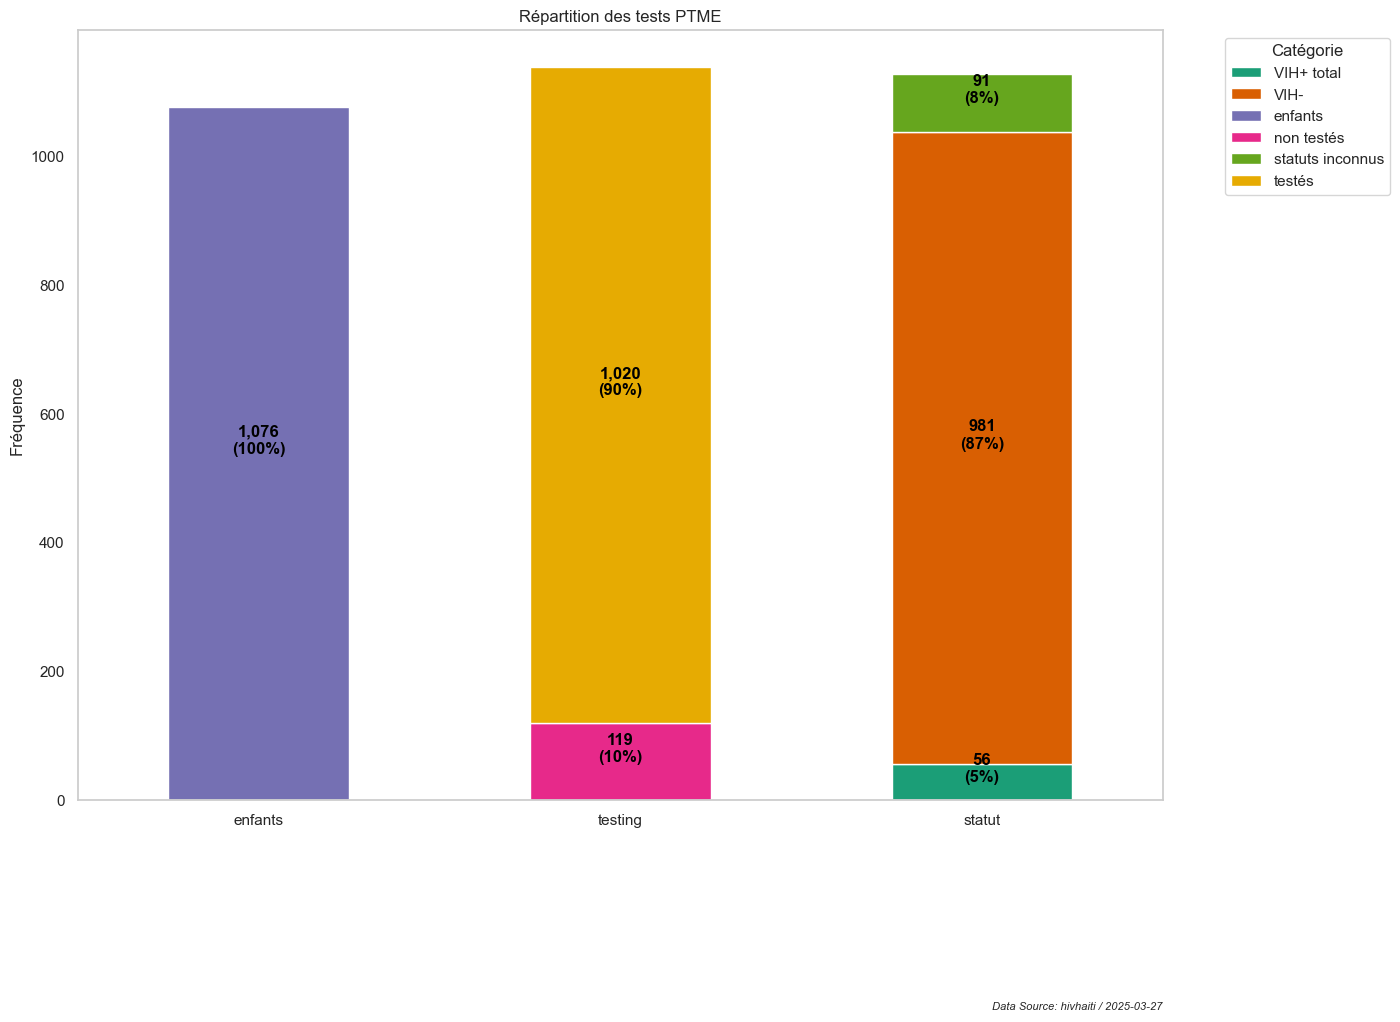

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def process_and_plot_data(eff_enf, enf_test, enf_vih_neg, no_info_status, enf_vih_pos_total, enf_non_test):
    """
    Process PTME test data and generate a stacked bar plot.
    """

    # Création du DataFrame
    df_ptme_test = pd.DataFrame({
        "variable": ["enfants", "testés", "VIH-", "statuts inconnus", "VIH+ total", "non testés"],
        "freq": [
            eff_enf["# Enfants"].count() if not eff_enf.empty else 0,
            enf_test["# Enfants testés"].count() if not enf_test.empty else 0,
            enf_vih_neg["# Enfants VIH-"].count() if not enf_vih_neg.empty else 0,
            no_info_status["# no_info_status"].count() if not no_info_status.empty else 0,
            enf_vih_pos_total["# Enfants VIH+"].count() if not enf_vih_pos_total.empty else 0,
            enf_non_test["# Enfants non testés"].count() if not enf_non_test.empty else 0
        ],
        "type": ["enfants", "testing", "statut", "statut", "statut", "testing"]
    })

    # Reorder the categories
    df_ptme_test["type"] = pd.Categorical(df_ptme_test["type"], categories=["enfants", "testing", "statut"], ordered=True)

    # Vérifier si le DataFrame est vide ou si toutes les fréquences sont nulles
    if df_ptme_test["freq"].sum() == 0:
        print("Aucune donnée disponible pour le graphique.")
        return

    # Conversion en numérique pour éviter les erreurs
    df_ptme_test["freq"] = pd.to_numeric(df_ptme_test["freq"], errors="coerce").fillna(0)

    # Pivot the DataFrame for stacked bar plot
    df_pivot = df_ptme_test.pivot(index='type', columns='variable', values='freq').fillna(0)

    # Création du graphique avec Seaborn
    ax = df_pivot.plot(kind='bar', stacked=True, figsize=(14, 10), color=sns.color_palette("Dark2"))

    # Ajouter les labels sur les barres
    for n, x in enumerate([*df_pivot.index.values]):
        for (proportion, y_loc) in zip(df_pivot.loc[x], df_pivot.loc[x].cumsum()):
            if proportion > 0:  # Skip zero values
                percentage = proportion / df_pivot.loc[x].sum() * 100
                plt.text(x=n, y=(y_loc - proportion) + (proportion / 2), 
                         s=f'{int(proportion):,}\n({percentage:.0f}%)', 
                         color="black", ha="center", fontweight="bold")

    # Personnalisation du graphique
    plt.xlabel("")
    plt.ylabel("Fréquence")
    plt.title("Répartition des tests PTME")
    plt.xticks(rotation=0)
    plt.grid(False)  # Remove gridlines

    # Déplacer la légende après l'axe
    plt.legend(title="Catégorie", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajouter la source de données
    plt.figtext(0.9, -0.1, f"Data Source: hivhaiti / {pd.Timestamp.today().date()}", ha="right", fontsize=8, style="italic")

    # Affichage du graphique
    plt.show()

# Appel de la fonction avec des DataFrames d'exemple
process_and_plot_data(eff_enf, enf_test, enf_vih_neg, no_info_status, enf_vih_pos_total, enf_non_test)

In [ ]:
# Créer le DataFrame med avec les indicateurs et leurs proportions
Indicators = ['enfants', 'testés', 'VIH-', 'statuts inconnus', 'VIH+ total', 'non testés']
n_1 = [eff_enf.shape[0], enf_test.shape[0], enf_vih_neg.shape[0], no_info_status.shape[0], enf_vih_pos_total.shape[0], enf_non_test.shape[0]]
prop_impact1 = [
    eff_enf.shape[0] / eff_enf.shape[0] if eff_enf.shape[0] != 0 else 0,
    enf_test.shape[0] / eff_enf.shape[0] if eff_enf.shape[0] != 0 else 0,
    enf_vih_neg.shape[0] / enf_test.shape[0] if enf_test.shape[0] != 0 else 0,
    no_info_status.shape[0] / enf_test.shape[0] if enf_test.shape[0] != 0 else 0,
    enf_vih_pos_total.shape[0] / enf_test.shape[0] if enf_test.shape[0] != 0 else 0,
    enf_non_test.shape[0] / eff_enf.shape[0] if eff_enf.shape[0] != 0 else 0
]
med = pd.DataFrame({'Indicators': Indicators, 'n_1': n_1, 'prop_impact1': prop_impact1})
med = med.sort_values(by='n_1', ascending=False)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Indicators', ylabel='n_1'>

Text(0, 1076, '1,076 (100%)')

Text(1, 1020, '1,020 (95%)')

Text(2, 981, '981 (96%)')

Text(3, 119, '119 (11%)')

Text(4, 91, '91 (9%)')

Text(5, 56, '56 (5%)')

Text(0.5, 1.0, 'Cascade des filles et fils testés')

Text(0.5, 0, '')

Text(0, 0.5, 'Frequency')

Text(0.5, -0.05, 'Data Source: hivhaiti / 2025-03-27')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'enfants'),
  Text(1, 0, 'testés'),
  Text(2, 0, 'VIH-'),
  Text(3, 0, 'non testés'),
  Text(4, 0, 'statuts inconnus'),
  Text(5, 0, 'VIH+ total')])

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 1000.0, '1000'),
  Text(0, 1200.0, '1200')])

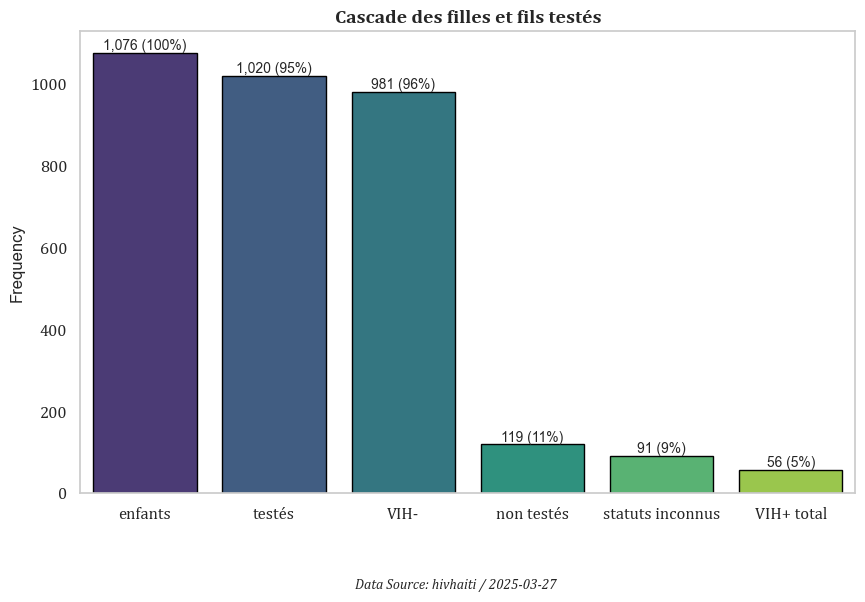

In [ ]:
# Vérifiez si le DataFrame med est vide
if med.empty:
    print("Il n'y a pas eu d'activite")
else:
    # Création du graphique, doublement de la largeur
    plt.figure(figsize=(10, 6))
    sns.barplot(data=med, x='Indicators', y='n_1', palette='viridis', edgecolor='black')

    # Ajout des labels sur les barres, centré en haut
    for i in range(len(med)):
        plt.text(i, med['n_1'].iloc[i], f"{med['n_1'].iloc[i]:,} ({med['prop_impact1'].iloc[i] * 100:.0f}%)", ha='center', va='bottom', size=10)

    # Titre et étiquettes
    plt.title("Cascade des filles et fils testés", fontsize=14, family='Cambria', fontweight='bold', ha='center')
    plt.xlabel("")
    plt.ylabel("Frequency")

    # Ajout de la source des données en tant que légende
    plt.figtext(0.5, -0.05, f"Data Source: hivhaiti / {pd.to_datetime('today').date()}", ha="center", fontsize=10, family='Cambria', style='italic')

    # Ajustement des thèmes
    plt.xticks(fontsize=12, family='Cambria')
    plt.yticks(fontsize=12, family='Cambria')

    # Suppression des gridlines
    plt.grid(False)

    # Afficher le graphique
    plt.show()


In [ ]:
for name, data in zip(databox_names, databox):
    if data is not None:
        print(f"data for {name}.")
        display(data.head(1))
        # display(data.head(2))  # Décommenter si utilisé dans Jupyter
    else:
        print(f"Failed to load data for {name}.")


data for commcare_ptme_no.


,site,Hospital,network_name,first_name,last_name,dob,id_patient,patient_code,created_at,age,...,club_session_date_result,last_session_date_result,dead,abandoned,club_q1,club_q2,participation,on_commCare,comptage,testing
16,CAP/CALT,Centre de Sante Avec Lits Trou-du-Nord,autres,Jean,Roselande,2004-11-20 00:00:00,20998,CAP/CALT/ST00849,2015-09-14 13:38:32,20,...,2025-03-13,2025-01-16 00:00:00,0,0,no,yes,En_club_q1_no_q2_yes,no,no,yes


data for commcare_ptme_yes.


,site,Hospital,network_name,first_name,last_name,dob,id_patient,patient_code,created_at,age,...,club_session_date_result,last_session_date_result,dead,abandoned,club_q1,club_q2,participation,on_commCare,comptage,testing
0,CAP/CALT,---,---,Joseph,Roseline,1980-01-15 00:00:00,---,CAP/CALT/ST00038,---,---,...,---,2024-12-04 00:00:00,0,0,yes,no,En_club_q1_yes_q2_no,yes,no,no


data for no_info_status.


,# no_info_status,count
0,PAP/NPFS/ST02937,4


data for enf_vih_neg.


,# Enfants VIH-,count
0,PAP/HFSC/ST03586,14


data for enf_vih_pos_total.


,# Enfants VIH+,count
0,PAP/HSFS/ST00930,2


data for enf_vih_pos.


,# Enfants VIH+ avec ST code,count
0,PIG/CSSR/ST00020,2


data for enf_non_test.


,# Enfants non testés,count
0,PAP/HOCH/ST00375,7


data for enf_test.


,# Enfants testés,count
0,PAP/KERJ/ST00361,14


data for eff_enf.


,# Enfants,count
0,PAP/KERJ/ST00361,14


In [ ]:
# Ajouter une colonne 'site' pour chaque DataFrame
eff_enf['site'] = eff_enf['# Enfants'].str[:8]
enf_test['site'] = enf_test['# Enfants testés'].str[:8]
enf_vih_neg['site'] = enf_vih_neg['# Enfants VIH-'].str[:8]
no_info_status['site'] = no_info_status['# no_info_status'].str[:8]
enf_vih_pos_total['site'] = enf_vih_pos_total['# Enfants VIH+'].str[:8]
enf_non_test['site'] = enf_non_test['# Enfants non testés'].str[:8]

# Vérifier les premières lignes pour chaque DataFrame
display(eff_enf.head(1))
display(enf_test.head(1))
display(enf_vih_neg.head(1))
display(no_info_status.head(1))
display(enf_vih_pos_total.head(1))
display(enf_non_test.head(1))

,# Enfants,count,site
0,PAP/KERJ/ST00361,14,PAP/KERJ


,# Enfants testés,count,site
0,PAP/KERJ/ST00361,14,PAP/KERJ


,# Enfants VIH-,count,site
0,PAP/HFSC/ST03586,14,PAP/HFSC


,# no_info_status,count,site
0,PAP/NPFS/ST02937,4,PAP/NPFS


,# Enfants VIH+,count,site
0,PAP/HSFS/ST00930,2,PAP/HSFS


,# Enfants non testés,count,site
0,PAP/HOCH/ST00375,7,PAP/HOCH


In [ ]:
# Appliquer la fonction merge_and_extend sur chaque DataFrame
eff_enf_merged = merge_and_extend(eff_enf, site, on='site')
enf_test_merged = merge_and_extend(enf_test, site, on='site')
enf_vih_neg_merged = merge_and_extend(enf_vih_neg, site, on='site')
no_info_status_merged = merge_and_extend(no_info_status, site, on='site')
enf_vih_pos_total_merged = merge_and_extend(enf_vih_pos_total, site, on='site')
enf_non_test_merged = merge_and_extend(enf_non_test, site, on='site')

# Afficher les premières lignes de chaque DataFrame fusionné pour vérifier
display(eff_enf_merged.head(1))
display(enf_test_merged.head(1))
display(enf_vih_neg_merged.head(1))
display(no_info_status_merged.head(1))
display(enf_vih_pos_total_merged.head(1))
display(enf_non_test_merged.head(1))

,# Enfants,count,site,status,caris_office,hopital,network,departement,commune,section,latitude,longitude
0,PAP/KERJ/ST00361,14,PAP/KERJ,Actif,Port-au-Prince,KLINIK ERITAG,BRIDGE,Ouest,Port-au-Prince,NaN,NaN,NaN


,# Enfants testés,count,site,status,caris_office,hopital,network,departement,commune,section,latitude,longitude
0,PAP/KERJ/ST00361,14,PAP/KERJ,Actif,Port-au-Prince,KLINIK ERITAG,BRIDGE,Ouest,Port-au-Prince,NaN,NaN,NaN


,# Enfants VIH-,count,site,status,caris_office,hopital,network,departement,commune,section,latitude,longitude
0,PAP/HFSC/ST03586,14,PAP/HFSC,Actif,Port-au-Prince,Hopital Foyer St Camille,CMMB,Ouest,Croix-des-Bouquets,Croix-des-Bouquets,18.61527,-72.288


,# no_info_status,count,site,status,caris_office,hopital,network,departement,commune,section,latitude,longitude
0,PAP/NPFS/ST02937,4,PAP/NPFS,Actif,Port-au-Prince,Hopital St Damien Nos Petits Freres et Soeurs,CMMB,Ouest,Tabarre,Tabarre,18.57037,-72.25368


,# Enfants VIH+,count,site,status,caris_office,hopital,network,departement,commune,section,latitude,longitude
0,PAP/HSFS/ST00930,2,PAP/HSFS,Actif,Port-au-Prince,Hopital St Francoise de Sales,CMMB,Ouest,Port-au-Prince,Port-au-Prince,18.538313,-72.346066


,# Enfants non testés,count,site,status,caris_office,hopital,network,departement,commune,section,latitude,longitude
0,PAP/HOCH/ST00375,7,PAP/HOCH,Inactif,Port-au-Prince,Hopital de la Communaute Haitienne,GHESKIO,Ouest,Petion-ville,Petion-ville,18.52405,-72.27233


In [ ]:
from datetime import date
import pandas as pd

def save_dataframes_excel(output_name="output", df1=None, df2=None, df3=None, df4=None, df5=None, df6=None, sheet_names=None):
    """
    Sauvegarde jusqu'à 6 DataFrames dans un fichier Excel avec un nom dynamique basé sur la date.

    Args:
        output_name (str): Nom de base du fichier de sortie (sans extension).
        df1, df2, df3, df4, df5, df6 (pd.DataFrame, optional): DataFrames à sauvegarder.
        sheet_names (list, optional): Liste des noms de feuilles.
    """
    # Définir une date pour le nom du fichier
    today_str = date.today().strftime("%Y-%m-%d")
    file_name = f"{output_name}_{today_str}.xlsx"

    # Définir les noms des feuilles si non fournis
    sheet_names = sheet_names or ['Sheet1', 'Sheet2', 'Sheet3', 'Sheet4', 'Sheet5', 'Sheet6']
    
    # Créer l'écrivain Excel
    writer = pd.ExcelWriter(file_name, engine='xlsxwriter')

    # Stocker les DataFrames dans une liste
    dfs = [df1, df2, df3, df4, df5, df6]

    # Écrire chaque DataFrame dans sa feuille correspondante s'il est défini
    for i, df in enumerate(dfs):
        if df is not None:
            df.to_excel(writer, sheet_name=sheet_names[i], index=False)

    # Sauvegarder le fichier Excel
    writer.close()
    print(f"Fichier '{file_name}' sauvegardé avec succès.")


In [ ]:
"""save_dataframe_to_excel(stat_ptme_index, 'stat_ptme_index')
save_dataframe_to_excel(working_data, 'working_data')"""

"save_dataframe_to_excel(stat_ptme_index, 'stat_ptme_index')\nsave_dataframe_to_excel(working_data, 'working_data')"

In [ ]:
# Example usage:
save_dataframes_excel(
	output_name="Statut_des_enfants_PTME",
	df1=eff_enf_merged,
	df2=enf_test_merged,
	df3=enf_vih_neg_merged,
	df4=no_info_status_merged,
	df5=enf_vih_pos_total_merged,
	df6=enf_non_test_merged,
	sheet_names=['PTME_0_17', 'testés', 'VIH-', 'statuts inconnus', 'VIH+ total', 'non testés']
)

Fichier 'Statut_des_enfants_PTME_2025-03-27.xlsx' sauvegardé avec succès.


### 6. Generate the pregnant report

In [ ]:
ptme_woman0 = working_data[(working_data.allaitante == 'yes') | (working_data.enceinte == 'yes')]
print(f"Number of PTME women with for the semester: {ptme_woman0.shape[0]}")
breasfeeding_woman = working_data[(working_data.allaitante == 'yes')]
print(f"Number of breasfeeding women with for the semester: {breasfeeding_woman.shape[0]}")
pregnant_woman = working_data[working_data['enceinte'] == 'yes']
print(f"Number of pregnant women with for the semester: {pregnant_woman.shape[0]}")
pregnant_woman_in_club = working_data[((working_data.club_q1 == 'yes') | (working_data.club_q2 == 'yes')) & ((working_data.enceinte == 'yes'))]
print(f"Number of pregnant women in club for the semester: {pregnant_woman_in_club.shape[0]}")
pregnant_woman_with_testing = pregnant_woman_in_club[pregnant_woman_in_club['testing'] == 'yes']
print(f"Number of pregnant women with Household count for the semester: {pregnant_woman_with_testing.shape[0]}")
pregnant_woman_with_comptage = pregnant_woman_in_club[pregnant_woman_in_club['comptage'] == 'yes']
print(f"Number of pregnant women with testing for their child: {pregnant_woman_with_comptage.shape[0]}")

Number of PTME women with for the semester: 2196
Number of breasfeeding women with for the semester: 2001
Number of pregnant women with for the semester: 197
Number of pregnant women in club for the semester: 22
Number of pregnant women with Household count for the semester: 17
Number of pregnant women with testing for their child: 20


In [ ]:
pregnant_woman_with_comptage.shape[0] / pregnant_woman_with_testing.shape[0]

1.1764705882352942

In [ ]:
# Créer le DataFrame med avec les indicateurs et leurs proportions
Indicators = ['Femme Enceinte(FE)', 'FE en club', 'FE avec enfants comptage', 'FE avec enfants testés']
n_1 = [pregnant_woman.shape[0], pregnant_woman_in_club.shape[0], pregnant_woman_with_comptage.shape[0], pregnant_woman_with_testing.shape[0]]
prop_impact1 = [
    pregnant_woman.shape[0] / pregnant_woman.shape[0] if ptme_woman0.shape[0] != 0 else 0,
    pregnant_woman_in_club.shape[0] / pregnant_woman.shape[0] if pregnant_woman.shape[0] != 0 else 0,
    pregnant_woman_with_comptage.shape[0] / pregnant_woman_in_club.shape[0] if pregnant_woman_in_club.shape[0] != 0 else 0,
    pregnant_woman_with_testing.shape[0] / pregnant_woman_with_comptage.shape[0] if pregnant_woman_with_comptage.shape[0] != 0 else 0,
]
medpregnant = pd.DataFrame({'Indicators': Indicators, 'n_1': n_1, 'prop_impact1': prop_impact1})
medpregnant = medpregnant.sort_values(by='n_1', ascending=False)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Indicators', ylabel='n_1'>

Text(0, 197, '197 (100%)')

Text(1, 22, '22 (11%)')

Text(2, 20, '20 (91%)')

Text(3, 17, '17 (85%)')

Text(0.5, 1.0, 'Cascades des femmes enceintes')

Text(0.5, 0, '')

Text(0, 0.5, 'Frequency')

Text(0.5, -0.05, 'Data Source: hivhaiti / 2025-03-27')

([0, 1, 2, 3],
 [Text(0, 0, 'Femme Enceinte(FE)'),
  Text(1, 0, 'FE en club'),
  Text(2, 0, 'FE avec enfants comptage'),
  Text(3, 0, 'FE avec enfants testés')])

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 [Text(0, 0.0, '0'),
  Text(0, 25.0, '25'),
  Text(0, 50.0, '50'),
  Text(0, 75.0, '75'),
  Text(0, 100.0, '100'),
  Text(0, 125.0, '125'),
  Text(0, 150.0, '150'),
  Text(0, 175.0, '175'),
  Text(0, 200.0, '200'),
  Text(0, 225.0, '225')])

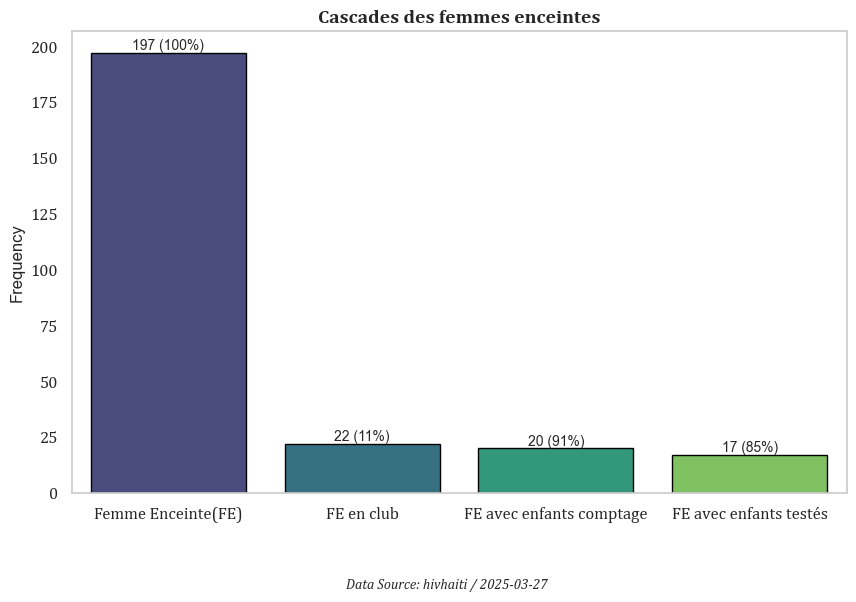

In [ ]:
# Vérifiez si le DataFrame med est vide
if medpregnant.empty:
    print("Il n'y a pas eu d'activite")
else:
    # Création du graphique, doublement de la largeur
    plt.figure(figsize=(10, 6))
    sns.barplot(data=medpregnant, x='Indicators', y='n_1', palette='viridis', edgecolor='black')

    # Ajout des labels sur les barres, centré en haut
    for i in range(len(medpregnant)):
        plt.text(i, medpregnant['n_1'].iloc[i], f"{medpregnant['n_1'].iloc[i]:,} ({medpregnant['prop_impact1'].iloc[i] * 100:.0f}%)", ha='center', va='bottom', size=10)

    # Titre et étiquettes
    plt.title("Cascades des femmes enceintes", fontsize=14, family='Cambria', fontweight='bold', ha='center')
    plt.xlabel("")
    plt.ylabel("Frequency")

    # Ajout de la source des données en tant que légende
    plt.figtext(0.5, -0.05, f"Data Source: hivhaiti / {pd.to_datetime('today').date()}", ha="center", fontsize=10, family='Cambria', style='italic')

    # Ajustement des thèmes
    plt.xticks(fontsize=12, family='Cambria')
    plt.yticks(fontsize=12, family='Cambria')

    # Suppression des gridlines
    plt.grid(False)

    # Afficher le graphique
    plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

def plot_ptme_distribution(commcare_ptme_yes, commcare_ptme_no):
    """
    Create a pie chart to visualize PTME distribution.
    
    Args:
        commcare_ptme_yes (pd.DataFrame): DataFrame containing 'on_commCare' for 'yes' cases.
        commcare_ptme_no (pd.DataFrame): DataFrame containing 'on_commCare' for 'no' cases.
        no_accept (pd.DataFrame): DataFrame containing 'patient_code' for refusals.

    Returns:
        plotly.graph_objects.Figure: A pie chart figure.
    """
    # Create the data frame for plotting
    dat_ind_ptme = pd.DataFrame({
        "comptage": ["Femmes allaitantes", "Femmes encientes"],
        "effectif": [len(commcare_ptme_yes["on_commCare"]),
                     len(commcare_ptme_no["on_commCare"])]
    })

    # Check if the data frame is empty
    if dat_ind_ptme.empty:
        print("Il n'y a pas d'activité")
        return None
    else:
        # Create a pie chart using Plotly
        fig = px.pie(dat_ind_ptme, names="comptage", values="effectif",
                     title="Répartition des femmes PTME selon leur statut", hole=0.3)
        fig.update_traces(textinfo='value+percent', insidetextorientation='radial')
        return fig
fig = plot_ptme_distribution(commcare_ptme_yes, commcare_ptme_no)
fig.show()

In [ ]:
fig = plot_ptme_distribution(breasfeeding_woman, pregnant_woman)
fig.show()

In [ ]:
"""import pandas as pd
column_list = [
    "site", "Hospital", "first_name", "last_name", "dob", "ptme_age", "in_club", 
    "is_actually_in_club", "Club_name", "why_this_woman_does_not_belong_to_a_club", 
    "this_woman_does_not_belong_to_a_club_reason_other", "woman_does_not_belong_to_a_club_definition", 
    "delivery_date_merge", "delivery_probality_date_merge", "DPA_calculated", 
    "allaitante", "enceinte", "pregnancy_quarter", "last_session_date_result", 
    "club_q1", "club_q2", "participation", "on_commCare"
]

# Création d'un writer pour enregistrer les données dans un fichier Excel
with pd.ExcelWriter("Analyse_Comptage_Menage.xlsx") as writer:
        # Filtrage et transformation de comm_ptme_mix
    comptage_ptme_no_0 = comm_ptme_mix.drop_duplicates(subset=["patient_code"], keep="first")
    comptage_ptme_no_0 = comptage_ptme_no_0[
        (comptage_ptme_no_0["on_commCare"] == "no") &
        (~comptage_ptme_no_0["patient_code"].isin(accept["patient_code"]))
    ]
    comptage_ptme_no_0["site_code"] = comptage_ptme_no_0["patient_code"].str[:8]
    comptage_ptme_no_0 = comptage_ptme_no_0[column_list]
    
    # Écriture de comptage_ptme_no_0 dans une autre feuille
    comptage_ptme_no_0.to_excel(writer, sheet_name="PTME_sans_comptage", index=False)
    # Filtrage de compt_ptme4 pour les patients VIH positifs
    # Filtrage de comm_ptme_mix où on_commCare est "yes"
    ind_al_ptme = comm_ptme_mix[comm_ptme_mix["on_commCare"] == "yes"]
    #ind_al_ptme.to_excel(writer, sheet_name="ind_al_ptme", index=False)
    
    # Conversion de age_in_year en numérique pour éviter les erreurs
    compt_ptme4["age_in_year"] = pd.to_numeric(compt_ptme4["age_in_year"], errors="coerce")
    
    # Filtrage de compt_ptme4 avec les conditions spécifiées
    ind_ptme_com = compt_ptme4[
        (compt_ptme4["ptme_relationship"] == "2") &
        (compt_ptme4["age_in_year"].between(0, 17)) &
        (compt_ptme4["hiv_test"].isin(["2", "non"])) &
        (compt_ptme4["non_consent_reason"] == "---")
    ][["patient_code", "owner_name", "first_name", "last_name", "name", "age_in_year", "hiv_test"]]
    
    # Écriture de ind_ptme_com dans une autre feuille
    ind_ptme_com.to_excel(writer, sheet_name="Enfants_non_testés", index=False)

    pos_vih_ptme = compt_ptme4[
        (compt_ptme4["ptme_relationship"] == "2") &
        (compt_ptme4["age_in_year"].between(0, 17)) &
        (compt_ptme4["hiv_test_result"] == "positif") &
        (compt_ptme4["hiv_test"].isin(["1", "oui"])) &
        (compt_ptme4["full_code_patient_menage"].isin(["//", "---"]))
    ][["patient_code", "name", "hiv_test", "hiv_test_result", "full_code_patient_menage", "age_in_year"]]
    
    # Écriture de pos_vih_ptme dans une autre feuille
    pos_vih_ptme.to_excel(writer, sheet_name="Pos_sans_ST", index=False)
    
    # Filtrage de compt_ptme4 pour les patients ayant un test inconnu
inconnu_ptme_com = compt_ptme4[
    (compt_ptme4["ptme_relationship"] == "2") &
    (compt_ptme4["age_in_year"].between(0, 17)) &
    (compt_ptme4["hiv_test"].isin(["1", "oui"])) &
    (~compt_ptme4["hiv_test_result"].isin(["positif", "negatif"]))
][["patient_code", "owner_name", "first_name", "last_name", "name", "age_in_year", "hiv_test"]]

# Écriture de join_ptme_inconnu dans une autre feuille
inconnu_ptme_com.to_excel(writer, sheet_name="Enfant_statut_inconnu", index=False)"""


'import pandas as pd\ncolumn_list = [\n    "site", "Hospital", "first_name", "last_name", "dob", "ptme_age", "in_club", \n    "is_actually_in_club", "Club_name", "why_this_woman_does_not_belong_to_a_club", \n    "this_woman_does_not_belong_to_a_club_reason_other", "woman_does_not_belong_to_a_club_definition", \n    "delivery_date_merge", "delivery_probality_date_merge", "DPA_calculated", \n    "allaitante", "enceinte", "pregnancy_quarter", "last_session_date_result", \n    "club_q1", "club_q2", "participation", "on_commCare"\n]\n\n# Création d\'un writer pour enregistrer les données dans un fichier Excel\nwith pd.ExcelWriter("Analyse_Comptage_Menage.xlsx") as writer:\n        # Filtrage et transformation de comm_ptme_mix\n    comptage_ptme_no_0 = comm_ptme_mix.drop_duplicates(subset=["patient_code"], keep="first")\n    comptage_ptme_no_0 = comptage_ptme_no_0[\n        (comptage_ptme_no_0["on_commCare"] == "no") &\n        (~comptage_ptme_no_0["patient_code"].isin(accept["patient_code"]

([<matplotlib.patches.Wedge at 0x214988d6270>,
 [Text(0.8899186825075615, 0.6465637930815537, 'A'),
  Text(-0.6465637258945605, 0.8899187313217674, 'B'),
  Text(1.311736850028664e-08, -1.0999999999999999, 'C')],
 [Text(0.48541019045866984, 0.35267115986266556, '20.0%'),
  Text(-0.35267112321521477, 0.4854102170846003, '30.0%'),
  Text(7.1549282728836204e-09, -0.5999999999999999, '50.0%')])

Text(0.5, 1.0, 'Pie Chart avec Seaborn')

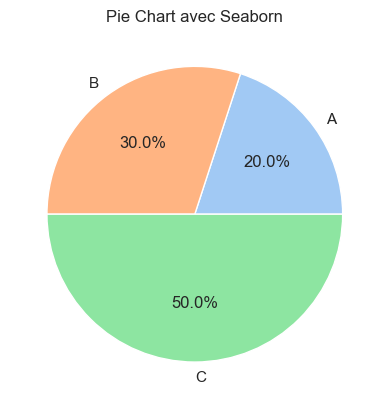

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.pie([20, 30, 50], labels=['A', 'B', 'C'], autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Pie Chart avec Seaborn")
plt.show()


In [ ]:
import plotly.express as px

df = px.data.gapminder().query("year == 2007").groupby("continent").sum().reset_index()
fig = px.pie(df, names='continent', values='pop', title="Pie Chart interactif avec Plotly", color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()


([<matplotlib.patches.Wedge at 0x214974491d0>,
 [Text(-1.0673251998086675, -0.2661144826073702, 'A'),
  Text(0.2661146564967135, -1.067325156453101, 'B'),
  Text(0.9328527021418345, 0.5829115165328939, 'C'),
  Text(-0.5829112236950298, 0.9328528851273191, 'D')],
 [Text(-0.5821773817138185, -0.14515335414947464, '30.0%'),
  Text(0.14515344899820737, -0.5821773580653277, '20.0%'),
  Text(0.5088287466228187, 0.3179517362906693, '40.0%'),
  Text(-0.31795157656092526, 0.5088288464330831, '10.0%')])

Text(0.5, 1.0, 'Pie Chart avec Matplotlib')

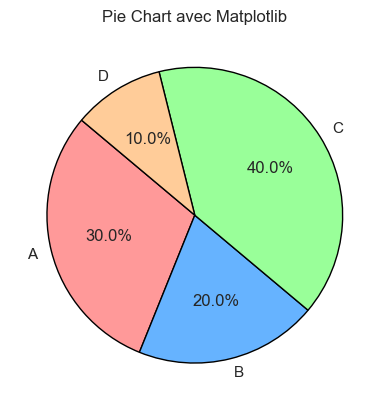

In [ ]:
import matplotlib.pyplot as plt

labels = ['A', 'B', 'C', 'D']
sizes = [30, 20, 40, 10]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Pie Chart avec Matplotlib")
plt.show()
